
Training Random Forest...
Random Forest Classification Report:
              precision    recall  f1-score   support

     Diurnal       0.80      0.73      0.76        59
   Nocturnal       0.80      0.73      0.76        59
 Crepuscular       0.80      0.93      0.86        61

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

Accuracy: 0.7989


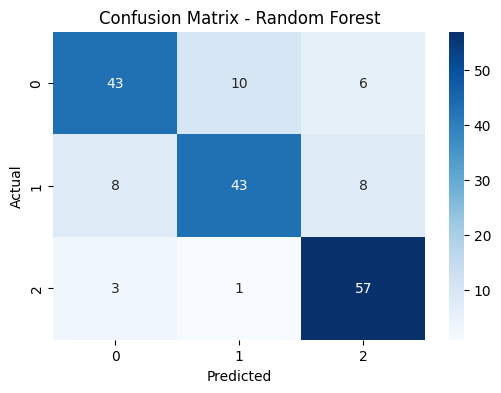


Training Gradient Boosting...
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

     Diurnal       0.87      0.78      0.82        59
   Nocturnal       0.84      0.78      0.81        59
 Crepuscular       0.80      0.93      0.86        61

    accuracy                           0.83       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.83      0.83       179

Accuracy: 0.8324


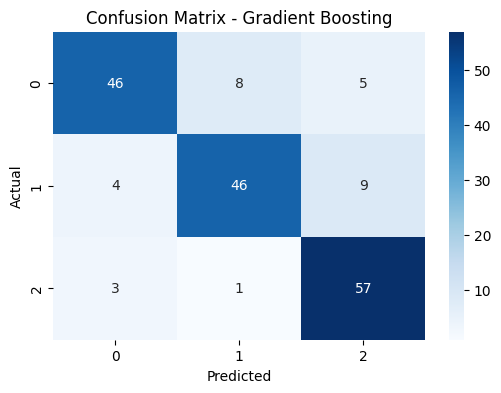


Training SVM...
SVM Classification Report:
              precision    recall  f1-score   support

     Diurnal       0.82      0.68      0.74        59
   Nocturnal       0.79      0.76      0.78        59
 Crepuscular       0.81      0.97      0.88        61

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

Accuracy: 0.8045


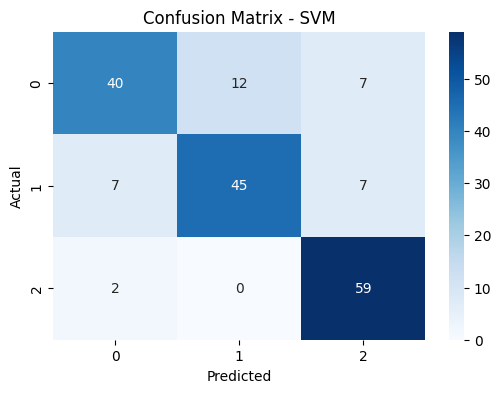


Training CatBoost...
CatBoost Classification Report:
              precision    recall  f1-score   support

     Diurnal       0.89      0.80      0.84        59
   Nocturnal       0.86      0.83      0.84        59
 Crepuscular       0.87      0.98      0.92        61

    accuracy                           0.87       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.87      0.87      0.87       179

Accuracy: 0.8715


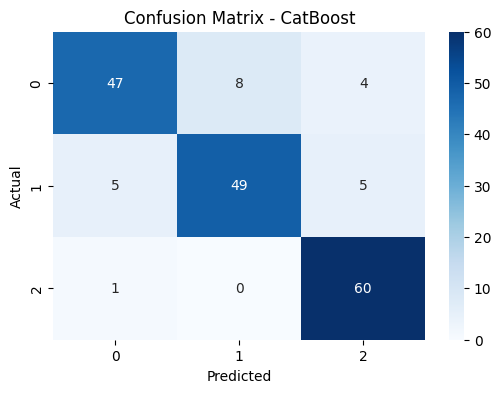


Training Stacking Classifier...
Stacking Classifier Report:
              precision    recall  f1-score   support

     Diurnal       0.77      0.81      0.79        59
   Nocturnal       0.86      0.75      0.80        59
 Crepuscular       0.88      0.95      0.91        61

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179

Accuracy: 0.8380


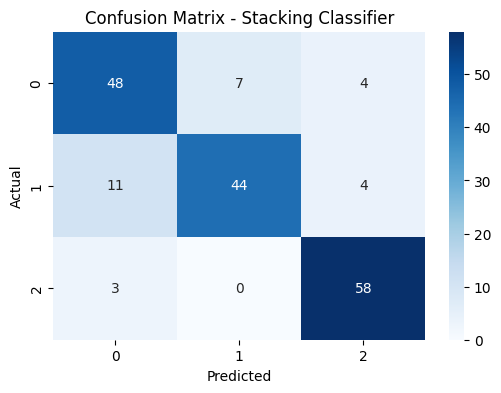


Accuracy per Species:
Diurnal: 0.8136
Nocturnal: 0.7458
Crepuscular: 0.9508
✅ Model evaluation complete.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install catboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from imblearn.combine import SMOTETomek
from catboost import CatBoostClassifier

# Load dataset
file_path = "/content/drive/MyDrive/Impact of 5G Electromagnetic Radiation on Animal Behaviour, Health, and Ecosystems.csv"
df = pd.read_csv(file_path)

# Strip whitespace from column names
df.columns = df.columns.str.strip()

# Target column
target_column = 'Activity Pattern'
if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found.")

# Separate features and target
X = df.drop(columns=[target_column])
y = df[target_column]

# Identify column types
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()
categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

# Handle missing values
if numerical_cols:
    X[numerical_cols] = X[numerical_cols].apply(pd.to_numeric, errors='coerce')
    X[numerical_cols] = X[numerical_cols].fillna(X[numerical_cols].median())

if categorical_cols:
    X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])
    encoder = LabelEncoder()
    for col in categorical_cols:
        X[col] = encoder.fit_transform(X[col])

# Store species names before encoding
y_unique_labels = y.unique()
y_mapping = {label: idx for idx, label in enumerate(y_unique_labels)}
y_inverse_mapping = {v: k for k, v in y_mapping.items()}
y = y.map(y_mapping)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using RFECV
rfe_selector = RFECV(estimator=RandomForestClassifier(n_estimators=100), step=1, cv=5, scoring='accuracy')
X_selected = rfe_selector.fit_transform(X_scaled, y)

# Resampling using SMOTETomek
sm = SMOTETomek(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_selected, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

# Define base models
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
svm = SVC(kernel='rbf', C=1.0, probability=True, random_state=42)
catboost = CatBoostClassifier(verbose=0, random_state=42)

base_models = {
    "Random Forest": rf,
    "Gradient Boosting": gb,
    "SVM": svm,
    "CatBoost": catboost
}

# Evaluate base models
for name, model in base_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred, target_names=[y_inverse_mapping[i] for i in sorted(y_inverse_mapping)]))
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('svm', svm),
        ('cat', catboost)
    ],
    final_estimator=GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
    passthrough=True
)

print("\nTraining Stacking Classifier...")
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_test)

print("Stacking Classifier Report:")
print(classification_report(y_test, y_pred_stack, target_names=[y_inverse_mapping[i] for i in sorted(y_inverse_mapping)]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Stacking Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Accuracy per species
species_names = [y_inverse_mapping[i] for i in sorted(y_inverse_mapping)]
species_accuracies = {}
for i, species in enumerate(species_names):
    idx = y_test == i
    species_accuracies[species] = accuracy_score(y_test[idx], y_pred_stack[idx])

print("\nAccuracy per Species:")
for species, acc in species_accuracies.items():
    print(f"{species}: {acc:.4f}")

print("✅ Model evaluation complete.")
